# Show the disaggregator overview

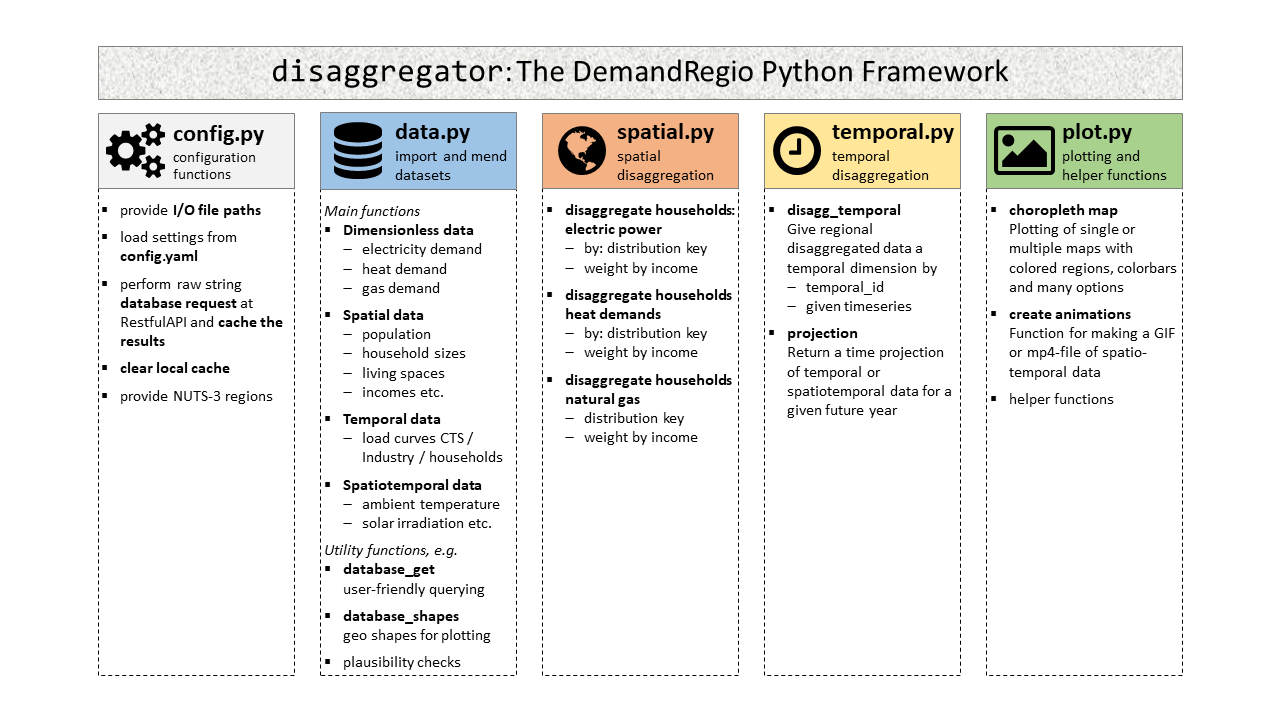

In [2]:
from IPython.display import Image
pic = Image(filename=('./img/overview.png'))
pic

# Spatial disaggregation with `spatial.py`

Now, as we've gathered a spatial feeling for the relevant input data in the first notebook, let's take a look at the spatial disaggregation abilities.

In [3]:
import pandas as pd
from disaggregator import config, data, spatial, plot

## Electric Power Consumption in [GWh/a]

The disaggregation method for the electric power consumption of private households is `spatial.disagg_households_power()` and requires at least one argument:

1. ``by`` is the distribution key and must be one of ``['population', 'households']``.  

    Using ``population`` invokes a *top-down*-method, i.e. the overall electricity consumption of entire Germany is being spread by distribution keys based on the population to calculate the consumption per region.  
    Using ``households`` invokes a *bottom-up*-method, i.e. the average electricity consumptions known for each household size are used for calculating the consumption per region.

Additionally, an income adjustment can be performed, through the switch ``weight_by_income=True``.

Let's start with ``population``:

In [4]:
ec_pop = spatial.disagg_households_power(by='population', weight_by_income=False)
ec_pop.head()

nuts3
DE111   1,001.919
DE112     612.457
DE113     841.913
DE114     405.994
DE115     857.891
Name: value, dtype: float64

... and continue with ``households``:

In [5]:
ec_hh = spatial.disagg_households_power(by='households', weight_by_income=False)
ec_hh.head()

hh_size,1,2,3,4,5,6
nuts3,,,,,,
DE111,306.976,297.056,158.990,137.590,56.357,27.767
DE112,121.320,172.360,106.016,110.908,42.361,17.855
DE113,181.519,246.359,144.365,146.807,52.937,22.088
DE114,77.681,115.019,71.918,73.061,27.868,11.957
DE115,181.499,258.664,142.738,149.889,53.577,22.485


So, do these two fundamentally different methods lead to comparable results? Let's check, by summing the consumptions of all six household types per region:

In [6]:
ec_hh.head().sum(axis=1)

nuts3
DE111   984.736
DE112   570.821
DE113   794.074
DE114   377.504
DE115   808.852
dtype: float64

Okay, that seems comparable.  
Let's further check the results by plotting these side by side on *one* map. We can achieve this, by merging the results into one new ``pd.DataFrame`` :

In [7]:
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1)], keys=['population', 'households'], axis=1, join='inner')
ec_combined.head()

,population,households
nuts3,,
DE111,"1,001.919",984.736
DE112,612.457,570.821
DE113,841.913,794.074
DE114,405.994,377.504
DE115,857.891,808.852


... and plot:

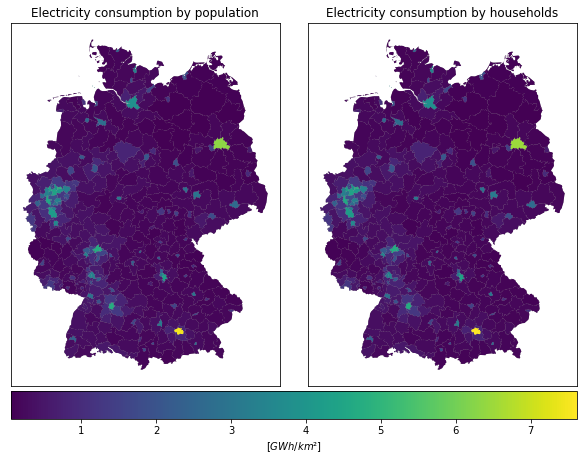

In [8]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh', axtitle='Electricity consumption by', add_percentages=False)

Now let's weight the consumptions by the available income:

In [9]:
ec_pop_ic = spatial.disagg_households_power(by='population', weight_by_income=True)
ec_hh_ic = spatial.disagg_households_power(by='households', weight_by_income=True)
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1), ec_pop_ic, ec_hh_ic.sum(axis=1)],
                        keys=['population', 'households', 'population (weighted)', 'households (weighted)'],
                        axis=1, join='inner')

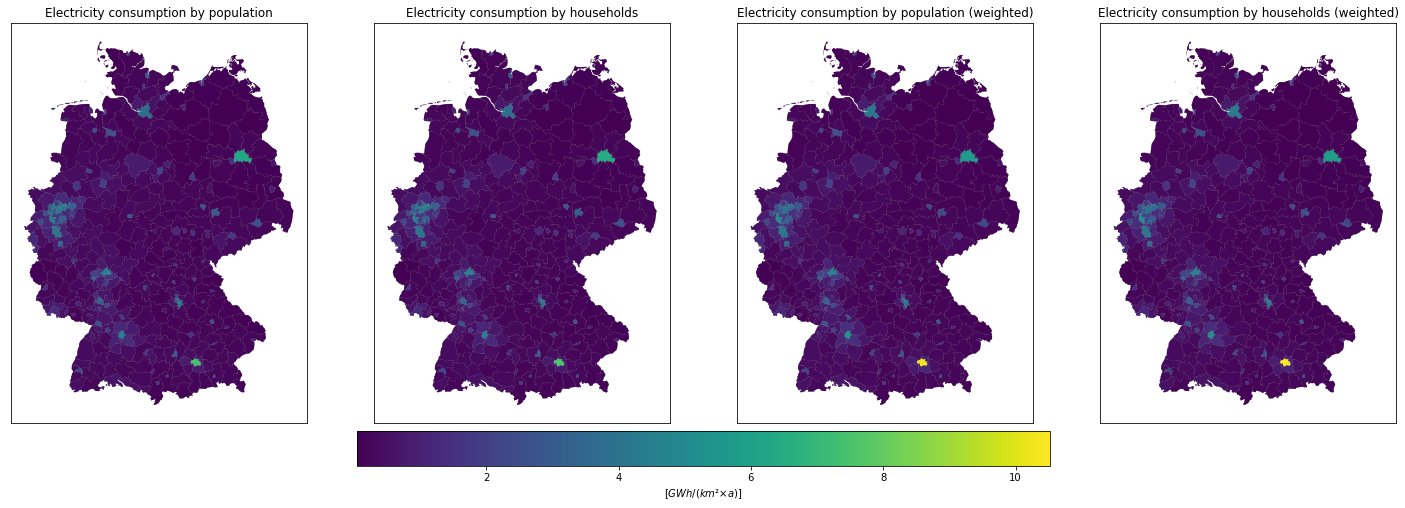

In [10]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh/a', axtitle='Electricity consumption by',
                              add_percentages=False, figsize=(20,12), nrows=1, ncols=4)

Now save this figure e.g. as PDF file:

In [11]:
from disaggregator.config import _data_out
fig.savefig(_data_out('disagg_households_power.pdf'), bbox_inches='tight')

## Gas consumption in [MWh/a]

The gas demands of private households are threefold:
1. cooking (=process heat)
2. warm water
3. space heating

The first two ones depend mainly on the **household size**, whereas the latter depends mainly on the **size of the building**. However, centralized space heating systems are very often also used as boilers for the hot water supply.

In [12]:
df_gas_td = spatial.disagg_households_gas(how='top-down')
df_gas_td.head()

disaggregator.spatial: INFO     Calculating regional gas demands top-down.


,Cooking,HotWater,SpaceHeating
nuts3,,,
DE111,"8,521.563","337,979.141","961,926.648"
DE112,"4,560.001","206,601.209","700,709.681"
DE113,"6,454.651","284,003.849","960,096.499"
DE114,"3,003.337","136,954.763","513,794.773"
DE115,"6,571.148","289,393.738","1,033,030.334"


In [13]:
df_gas_bu = spatial.disagg_households_gas(how='bottom-up')
df_gas_bu.head()

disaggregator.spatial: INFO     Calculating regional gas demands bottom-up.


,Cooking,HotWater,SpaceHeating
nuts3,,,
DE111,"8,521.563","337,979.141","848,858.277"
DE112,"4,560.001","206,601.209","715,476.270"
DE113,"6,454.651","284,003.849","931,479.321"
DE114,"3,003.337","136,954.763","501,044.406"
DE115,"6,571.148","289,393.738","963,624.306"


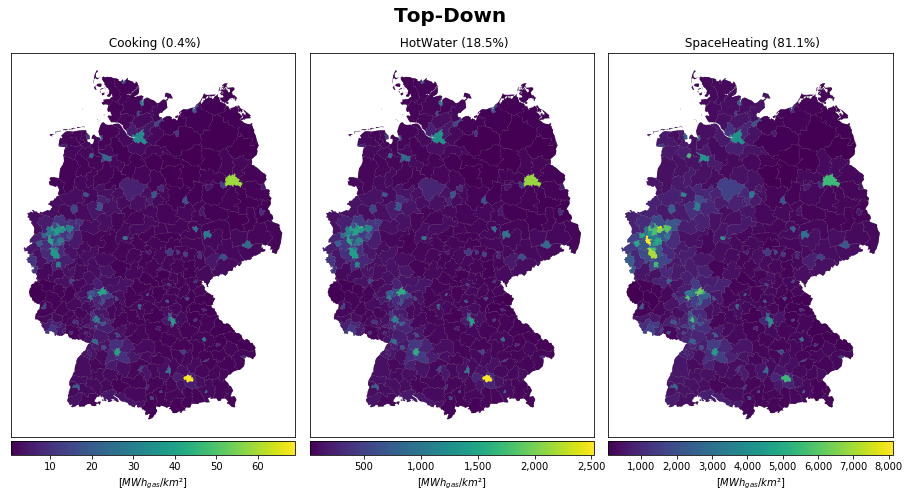

In [18]:
fig, ax = plot.choropleth_map(df_gas_td, unit='MWh_{gas}', colorbar_each_subplot=True, add_percentages=True, suptitle='Top-Down')

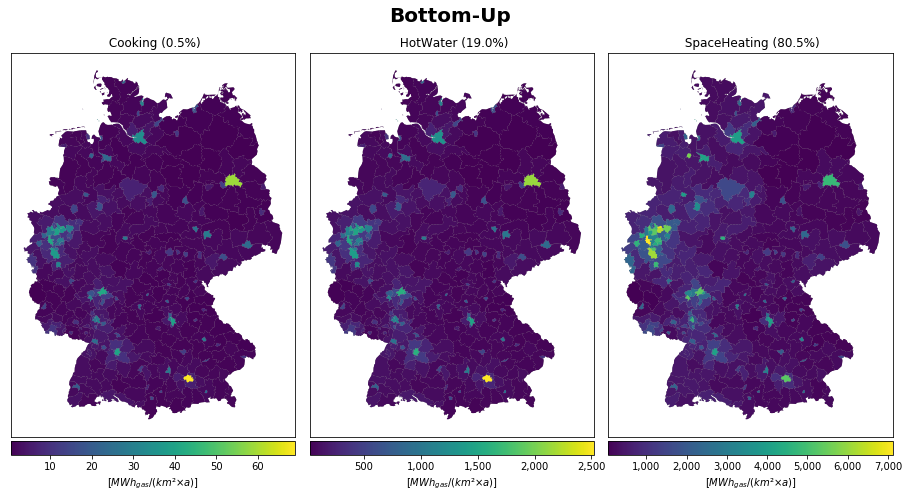

In [17]:
fig, ax = plot.choropleth_map(df_gas_bu, unit='MWh_{gas}/a', colorbar_each_subplot=True, add_percentages=True, suptitle='Bottom-Up')